## Inventory Optimization with Data Science: Hands-On Tutorial with Python

### Part 2: A Gentle Introduction to Implementing the Markov Process for Inventory Optimization.

### How to define reward in Inventory Management problems:

In the previous work, we worked on building a transition model of how states evolves. We defined state with two paremter $S_t = (\alpha , \beta)$, and the follwing plot shows how states evolves acodding toa fixed policy:

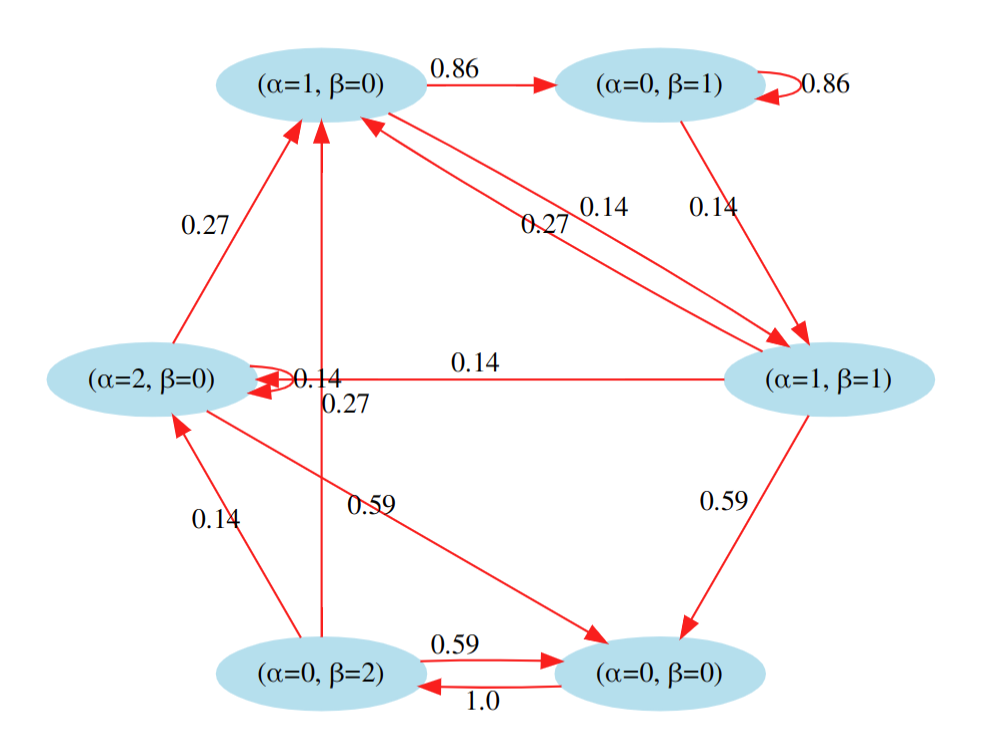

In [1]:
from IPython.display import Image, display
display(Image(filename="img/MarkovProcess.png"))



- **Markov Reward Process**

Markov Reward Process (in short MRP) is aMarkov Process, where sequence of "Rewards" satisfying the MArkov Reward Property as:

$$\mathbb{P}[(R_{t+1}, S_{t+1})|S_t,S_{t-1},\cdots,S_0] = \mathbb{P}[(R_{t+1}, S_{t+1})|S_t] $$

Here, $R_{t+1}$ is a reward induced if we move from state $S_{t}$ to $S_{t+1}$. Here, we are dealing with another dictionary, this time I call it **MarkovRewProcess_Exa** where it connects the states, to rewards. Let me explian how it look like:

In [7]:
from typing import Dict

from rich import pretty
pretty.install()

# need numpy to do some numeric calculation
import numpy as np

# poisson is used to find pdf of Poisson distribution 
from scipy.stats import poisson

import pandas as pd
import numpy as np


In [7]:
MarkovRewProcess_Exa = {"Current State A":{("NextS1fromA",  "RewardS1fromA"):"PNextS1fromA",
                                           ("NextS2fromA", "RewardS2fromA"):"PNextS2fromA"},
                    
                     "Current State B":{("NextS1fromB",  "RewardS1fromB"):"PNextS1fromB",
                                       ("NextS2fromB",  "RewardS2fromB"):"PNextS2fromB"}}

The **MarkovRewProcess_Exa** is dictionary where the keys are the current state, $S_{t}$. Then At each state going to new state would have some rewards, and from state $S_t$ to tuple of $(S_{t+1}, R_{t+1})$ has a probability.  

In the below, you can see given the $S_{t}$ = Current State A to next (state, reward) written as ("NextS1fromA",  "RewardS1fromA"), the probaility of this move is **PNextS1fromA**


In [4]:
MarkovRewProcess_Exa["Current State A"][("NextS1fromA",  "RewardS1fromA")]

'PNextS1fromA'

And we can iterate over all possible (new state, reward) to get the over view of the process evolves:

In [9]:
for (state, value) in MarkovRewProcess_Exa.items():
    
    print("The Current state is: {}".format(state))
    
    for (next_state,reward),trans_prob  in value.items():
        
        print("The ({} with {}) \nwith Probability of: {} \
               ".format(next_state, reward, trans_prob ))

The Current state is: Current State A
The (NextS1fromA with RewardS1fromA) 
with Probability of: PNextS1fromA                
The (NextS2fromA with RewardS2fromA) 
with Probability of: PNextS2fromA                
The Current state is: Current State B
The (NextS1fromB with RewardS1fromB) 
with Probability of: PNextS1fromB                
The (NextS2fromB with RewardS2fromB) 
with Probability of: PNextS2fromB                


## Reward Modeling (two cases)

Now at this stage, we need to assign reward. What we mean is given you are at state $S_{t}$, if you move to state $S_{t+1}$, how much "cost" is accured. In the example of Inventory Management, we deal wit two diffrente cases. 
The cost is compromisedof two parts:

- 1) When we hold inventory items in the inventory, we are making cost of overnight holding cost. Imagine that holding items in inventory i costly (maintaance, or othe fees).
- 2) The another cost is misssed costumer cost, whih means that if you have three bicule in your inevtory, and 5 costumer, you are incurring 2 **missed costumer** cost.

In the example of inventory optimization:   


$$\textbf{Reward}: \text{Overnight holding cost} + \text{Missed Customer cost}$$

The first case is when the number of available items in inventory meet the "demand" the second case is for the situation where the demand exceeds the available items. We will start with case I:

- Case I ($0 \leq i \leq \alpha + \beta -1$ ) 

In this case we do not have any "Missed Customer cost". Meaning only we are dealing with overnight holding cost. We assume this cost of hover holding per bicycle (item) is equal to $h$. Note that states are "recorded" at each day 8 PM , 
Given this explanation, we can write that 

$$R((\alpha , \beta) \to ((\alpha + \beta) -i, C-(\alpha + \beta) ) = -h\alpha$$

Note that states are "recorded" at each day 8 PM . For example, today is Monday and there and at 8 PM you recoed that you have one bicyle on stock ($\alpha = 2$) and one bycle order that arrive tommor morning at 6AM ($\beta = 0$). If tommor demand is $i=1$. Given this, the reward is equal cost of holding $-h\alpha=-h\times2$ 

- Case II (demand excedding $(\alpha + \beta)$) 

This is teh case when demand $i$ is eqaul and graeter than all the bicyle you have in early morring, $\alpha + \beta$. In this case the cost is first $-h\alpha$ plus the **Missed Costumer cost** , whe the usnit cost of missed costumer is equal to $p$.

- $$R((\alpha , \beta) \to (0, C-(\alpha + \beta) ) = -h\alpha -p(\sum_{j=\alpha + \beta +1}^{\infin}f(j)(j-(\alpha +\beta)))$$
- $$=h\alpha-p(\lambda(1-F(\alpha+\beta-1)) - (\alpha+\beta)(1-F(\alpha+\beta)))$$

The second term of above equation needs to be explained. The term $p$ is simply the unit cost of missing costumer, then the term 
$$\sum_{j=\alpha + \beta +1}^{\infty}{f(j)(j-(\alpha + \beta))}$$
is equal to expected number of missed costumer, muliplied by $p$. (There is short dervivation how to reach the final euation, which I put in notes)

## Hands On Python Coding

In the below, We wrote a function which is generator of Markov Reward Process Dictionary. This final dictionary structure for the markov reward process is :

In [6]:
from typing import Dict, Tuple

MRP_dict: Dict[Tuple[int, int], Dict[Tuple[Tuple[int, int], float], float]] = {}

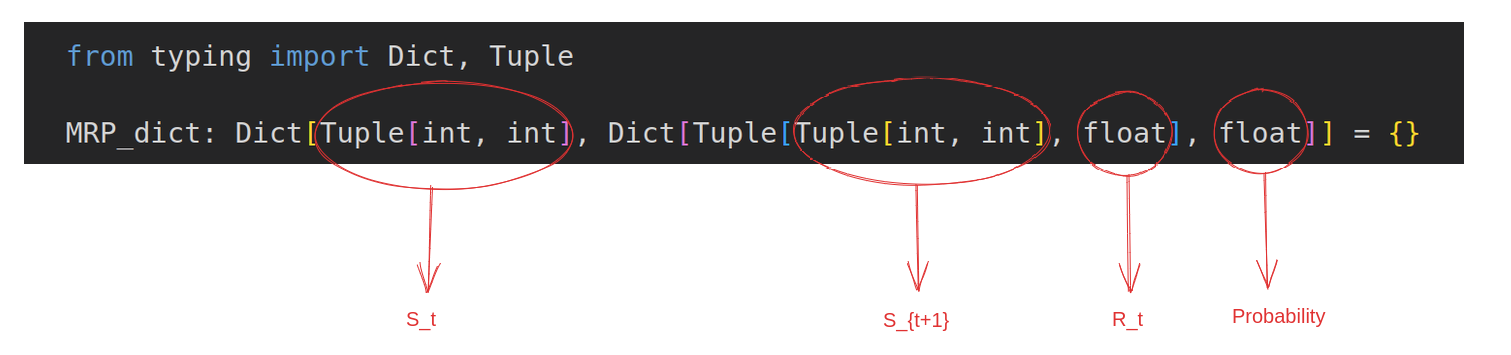

In [7]:
from IPython.display import Image, display
display(Image(filename="img/MRP_dict.png"))

In [2]:
from typing import Dict, Tuple
from scipy.stats import poisson

def generate_Markov_Rew_Process_Dict(user_capacity: int, user_poisson_lambda: int,
                                      holding_cost: int, missedcostumer_cost: int):
    """
    Generate a Markov Reward Process Dictionary based on the provided parameters.

    Args:
        user_capacity (int): The the capacity of the inventory.
        user_poisson_lambda (int): The Poisson lambda parameter.
        holding_cost (int): The unit cost of holding item in inventory overnight.
        missedcostumer_cost (int):The unit cost of missed costumer.
    Returns:
        Dict[Tuple[int, int], Dict[Tuple[Tuple[int, int], float], float]]: The Markov Reward Process Dictionary.
    """

    MRP_dict: Dict[Tuple[int, int], Dict[Tuple[Tuple[int, int], float], float]] = {}

    for alpha in range(user_capacity + 1):
        for beta in range(user_capacity + 1 - alpha):
            
            state = (alpha, beta)
            init_inv = alpha + beta
            beta1 = user_capacity - init_inv

            base_reward = -alpha * holding_cost
            
            for demand in range(init_inv + 1):
                    if demand <= (init_inv - 1):
                        
                        transition_prob = poisson.pmf(demand, user_poisson_lambda)
                                                
                        if state in MRP_dict:
                    
                            MRP_dict[state][((init_inv - demand, beta1), base_reward)]= transition_prob
                
                        else:
                    
                            MRP_dict[state] = {((init_inv - demand, beta1), base_reward):transition_prob}
                    
                    
                    else:
                        
                        transition_prob = 1 - poisson.cdf(init_inv - 1, user_poisson_lambda)
                        transition_prob2 = 1 - poisson.cdf(init_inv, user_poisson_lambda)
                        
                        
                        reward = base_reward - missedcostumer_cost * ((user_poisson_lambda * transition_prob) -
                                                                init_inv * transition_prob2)
                        
                        if state in MRP_dict:
                             
                             MRP_dict[state][((0, beta1),reward)]= transition_prob
                             
                        else:

                            MRP_dict[state] = {((0, beta1),reward):transition_prob}
                        

    return MRP_dict


Having the function, we can give the input of the function(same as the previous article) and then get the dictionary of Markov reward Process.

In [11]:
# Example usage:
inv_capacity_val = 2
poisson_lambda_val = 2.0
holding_cost_val = 1
missedcostumer_cost_val = 10

MRP_dict = generate_Markov_Rew_Process_Dict(
    user_capacity= inv_capacity_val, 
    user_poisson_lambda = poisson_lambda_val,
    holding_cost = holding_cost_val,
    missedcostumer_cost = missedcostumer_cost_val)


We can print out this dictionary and figure out how the dat has been store in the dictionary:

In [13]:
for (state, value) in MRP_dict.items():
    
    print("The Current state is: {}".format(state))
    
    for (next_state,reward),trans_prob  in value.items():
        
        print("The (State ,Reward): ({} , {:.2f}) occurs with Probability of: {:.2f} \
               ".format(next_state, reward, trans_prob ))
    

The Current state is: (0, 0)
The (State ,Reward): ((0, 2) , -20.00) occurs with Probability of: 1.00                
The Current state is: (0, 1)
The (State ,Reward): ((1, 1) , 0.00) occurs with Probability of: 0.14                
The (State ,Reward): ((0, 1) , -11.35) occurs with Probability of: 0.86                
The Current state is: (0, 2)
The (State ,Reward): ((2, 0) , 0.00) occurs with Probability of: 0.14                
The (State ,Reward): ((1, 0) , 0.00) occurs with Probability of: 0.27                
The (State ,Reward): ((0, 0) , -5.41) occurs with Probability of: 0.59                
The Current state is: (1, 0)
The (State ,Reward): ((1, 1) , -1.00) occurs with Probability of: 0.14                
The (State ,Reward): ((0, 1) , -12.35) occurs with Probability of: 0.86                
The Current state is: (1, 1)
The (State ,Reward): ((2, 0) , -1.00) occurs with Probability of: 0.14                
The (State ,Reward): ((1, 0) , -1.00) occurs with Probability of: 0.27  

One intersting data structure we can extract from a Markov Process or Markov rweard Process is the to build transition probality matrix. This matrix has x and y column of the states of the process, where each elemnet in the matrix gives the value of the probaility of moving from that state (in the row) to the next state (in the column.)

## Bellman Equation:

The main idea of the Markov Reward Process is to figure out how much value on average each states will lead, if we continue process for long time. This is definition of the term name **Value Function** of state. It is defined as:

$$V(s) = \mathbb{E}[G_t|S_t=s] \quad \text{for all} \quad s \in \mathcal{N} $$

$$V(s) = \overline{R}(s) + \gamma \sum_{s' \in \mathcal{N}}\mathbb{P}(S_{t+1}=s'|S_t=s)V(S_{t+1}=s') $$

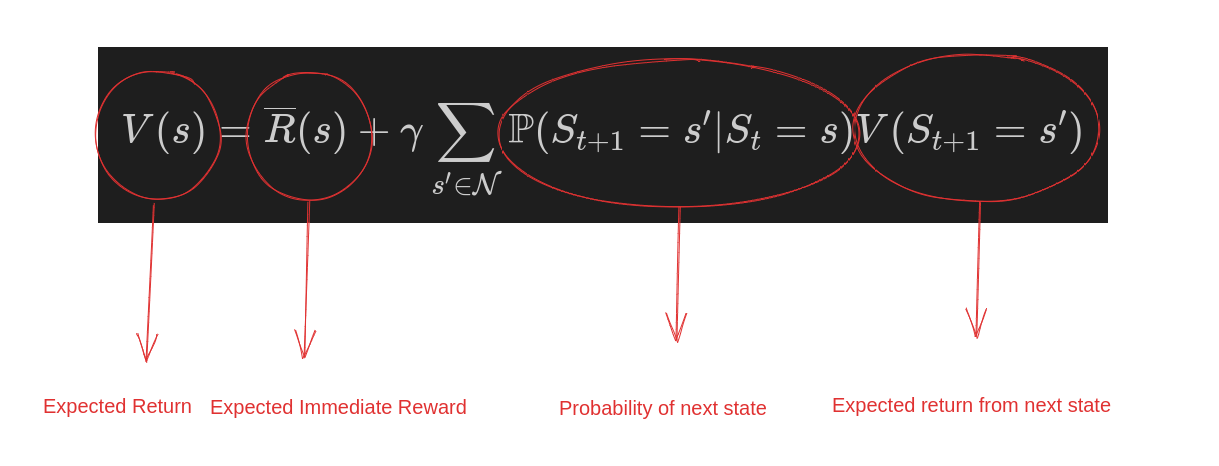

In [11]:
from IPython.display import Image, display
display(Image(filename="img/BellmanEq.png"))

The goal of the rest of this blog is to find value function $V(s)$, which cosnsit of three parts:

- Part I) Find the Expected Immediate Reward for all states
- Part II) Build the Transition Probability Matrix

### Part I) Find the Expected Immediate Reward

The below function will find the $\mathcal{R}(s)$ for all the states.In fact $\mathcal{R}(s)$ is the expected immediate reward for states in the inventory problem.  

In [3]:
def calculate_expected_immediate_rewards(MarkovRewProcessDict):
    """
    Calculate the expected immediate rewards for each state in a Markov Reward Process.

    Args:
        MarkovRewProcessDict (dict): Markov Reward Process Dictionary.

    Returns:
        dict: Dictionary with states as keys and their expected immediate rewards as values.
    """
    E_immediate_R = {}  # Initialize a dictionary to store expected immediate rewards

    for from_state, value in MarkovRewProcessDict.items():
        # Calculate the expected immediate reward for the current state
        expected_reward = sum(reward[1] * prob for (reward, prob) in value.items())
        E_immediate_R[from_state] = expected_reward

    return E_immediate_R

# Example usage:
# E_immediate_R = calculate_expected_immediate_rewards(MarkovRewProcessDict)


In [13]:
R_exp_imm =calculate_expected_immediate_rewards(MRP_dict)
R_exp_imm

{
    (0, 0): -20.0,
    (0, 1): -9.816843611112656,
    (0, 2): -3.2155346628164065,
    (1, 0): -10.816843611112656,
    (1, 1): -4.215534662816407,
    (2, 0): -5.215534662816407
}

### Part II) Build the Transition Probability Matrix

The transition probability matrix is the matrix which the column names and rows are the *states* of the Markov Reward Process and each cell, represent the conditional probability.

In [1]:
states = list(MRP_dict.keys())

df_trans_prob = pd.DataFrame(0.0, columns=states, index=states)
df_trans_prob

NameError: name 'MRP_dict' is not defined

The above is the intilization of the matrix. Now we can go and start filling out thi matrix as below: 

In [15]:
import numpy as np
import pandas as pd

def create_transition_probability_matrix(MarkovRewProcessDict):
    """
    Create a transition probability matrix from a Markov Reward Process Dictionary.

    Args:
        MarkovRewProcessDict (dict): Markov Reward Process Dictionary.

    Returns:
        pd.DataFrame: Transition probability matrix.
    """
    states = list(MarkovRewProcessDict.keys())
    num_states = len(states)

    # Initialize an empty matrix with zeros
    trans_prob = np.zeros((num_states, num_states))
    df_trans_prob = pd.DataFrame(trans_prob, columns=states, index=states)

    for i, from_state in enumerate(states):
        for j, to_state in enumerate(states):
            for (new_state, reward) in MarkovRewProcessDict.get(from_state, {}):
                if new_state == to_state:
                    probability = MarkovRewProcessDict[from_state].get((new_state, reward), 0.0)
                    df_trans_prob.iloc[i, j] = probability

    return df_trans_prob

In [16]:
df_trans_prob = create_transition_probability_matrix(MRP_dict)
df_trans_prob

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(2, 0)"
"(0, 0)",0.000000,0.000000,1.0,0.000000,0.000000,0.000000
"(0, 1)",0.000000,0.864665,0.0,0.000000,0.135335,0.000000
"(0, 2)",0.593994,0.000000,0.0,0.270671,0.000000,0.135335
"(1, 0)",0.000000,0.864665,0.0,0.000000,0.135335,0.000000
"(1, 1)",0.593994,0.000000,0.0,0.270671,0.000000,0.135335
"(2, 0)",0.593994,0.000000,0.0,0.270671,0.000000,0.135335


Let me explain what this matrix means. For example, think about third rows, which is state $S_t=(0,2)$, then the following probability can be written as:

- $\mathbb{P}(S_{t+1}=(0,0)| S_{t}=(0,2)) = 0.59$
- $\mathbb{P}(S_{t+1}=(1,0)| S_{t}=(0,2)) = 0.27$
- $\mathbb{P}(S_{t+1}=(2,0)| S_{t}=(0,2)) = 0.13$

Note that this matrix graphically has been shown before. The graph is here:

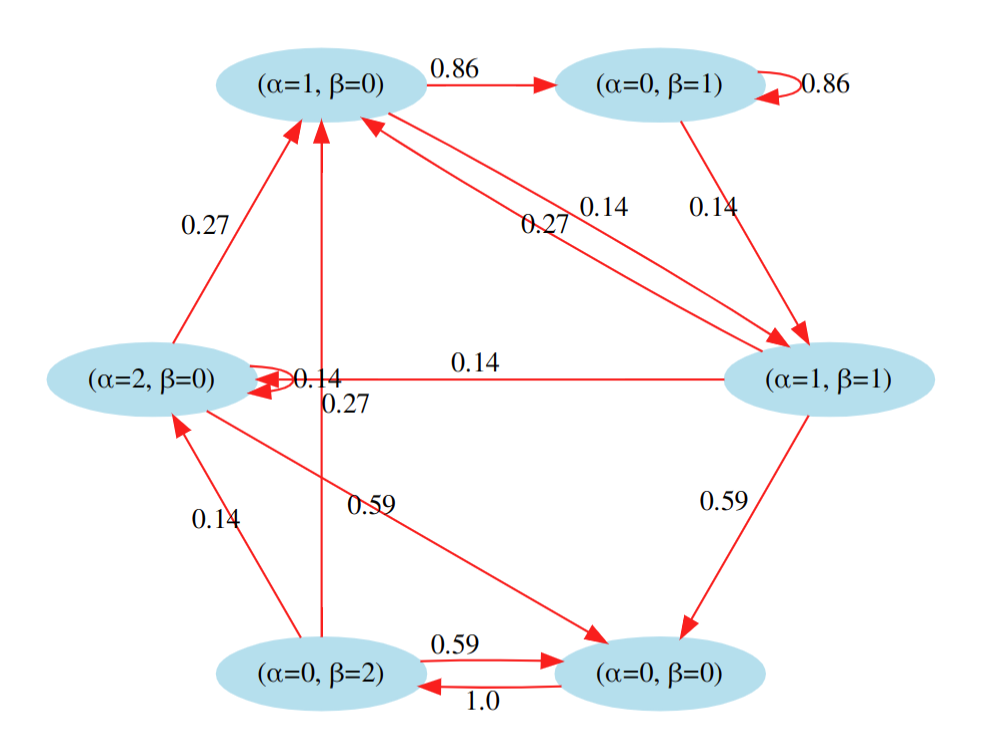

In [17]:
from IPython.display import Image, display
display(Image(filename="img/MarkovProcess.png"))


Now, having the transition matrix probability and expected immdeiate rewards of states, we can calculate the value function of each state, using the vector and matrix format as below: 

$$\mathbf{V} = \mathbf{R} + \gamma \mathbf{P}.\mathbf{V}$$
$$\Rightarrow \mathbf{V} = (I_m-\gamma\mathbf{P})^{-1}.\mathbf{R}$$

In [18]:
import numpy as np
import pandas as pd

def calculate_state_value_function(trans_prob_mat, expected_immediate_rew, gamma):
    """
    Calculate the state value function using transition probability matrix and expected immediate rewards.

    Args:
        trans_prob_mat (pd.DataFrame): Transition probability matrix.
        expected_immediate_rew (dict): Dictionary with states as keys and expected immediate rewards as values.
        gamma (float): Discount factor.

    Returns:
        pd.DataFrame: DataFrame with 'Expected Immediate Reward' and 'Value Function' columns indexed by states.
    """
    states = list(expected_immediate_rew.keys())

    R_exp = np.array(list(expected_immediate_rew.values()))

    # Calculate the value function vector using the equation
    val_func_vec = np.linalg.solve(np.eye(len(R_exp)) - gamma * trans_prob_mat, R_exp)

    # Create a DataFrame with 'Expected Immediate Reward' and 'Value Function' columns
    MarkRevData = pd.DataFrame({'Expected Immediate Reward': R_exp, 'Value Function': val_func_vec}, index=states)

    return MarkRevData

# Example usage:
# MarkRevData = calculate_state_value_function(df_trans_prob, E_immediate_R, gamma)

In [19]:
calculate_state_value_function(trans_prob_mat=df_trans_prob, expected_immediate_rew=R_exp_imm, gamma=0.9)

,Expected Immediate Reward,Value Function
"(0, 0)",-20.000000,-106.517791
"(0, 1)",-9.816844,-97.598665
"(0, 2)",-3.215535,-96.130879
"(1, 0)",-10.816844,-98.598665
"(1, 1)",-4.215535,-97.130879
"(2, 0)",-5.215535,-98.130879


You can see that for example in above table,the state $(0,2)$ has the highest expected immediate reward and value function.


One way is we can put all codes together and make MarkovRewardProcess class, and call modules of the class.
I have put full code (less than 100 lines) here:

In [8]:
from typing import Dict, Tuple
from scipy.stats import poisson
import numpy as np
import pandas as pd

class MarkovRewardProcess:
    def __init__(self):
        self.MRP_dict = {}

    def generate_Markov_Rew_Process_Dict(self, user_capacity: int, user_poisson_lambda: int,
                                          holding_cost: int, missedcostumer_cost: int):
        self.MRP_dict = {}  # Initialize the Markov Reward Process Dictionary

        for alpha in range(user_capacity + 1):
            for beta in range(user_capacity + 1 - alpha):
            
                state = (alpha, beta)
                init_inv = alpha + beta
                beta1 = user_capacity - init_inv

                base_reward = -alpha * holding_cost
            
                for demand in range(init_inv + 1):
                    if demand <= (init_inv - 1):
                        transition_prob = poisson.pmf(demand, user_poisson_lambda)
                                                
                        if state in self.MRP_dict:
                            self.MRP_dict[state][((init_inv - demand, beta1), base_reward)] = transition_prob
                        else:
                            self.MRP_dict[state] = {((init_inv - demand, beta1), base_reward): transition_prob}
                    else:
                        transition_prob = 1 - poisson.cdf(init_inv - 1, user_poisson_lambda)
                        transition_prob2 = 1 - poisson.cdf(init_inv, user_poisson_lambda)
                        reward = base_reward - missedcostumer_cost * ((user_poisson_lambda * transition_prob) -
                                                                init_inv * transition_prob2)
                        if state in self.MRP_dict:
                            self.MRP_dict[state][((0, beta1), reward)] = transition_prob
                        else:
                            self.MRP_dict[state] = {((0, beta1), reward): transition_prob}

    def calculate_expected_immediate_rewards(self):
        E_immediate_R = {}
        for from_state, value in self.MRP_dict.items():
            expected_reward = sum(reward[1] * prob for (reward, prob) in value.items())
            E_immediate_R[from_state] = expected_reward
        return E_immediate_R

    def create_transition_probability_matrix(self):
        states = list(self.MRP_dict.keys())
        num_states = len(states)
        trans_prob = np.zeros((num_states, num_states))
        df_trans_prob = pd.DataFrame(trans_prob, columns=states, index=states)

        for i, from_state in enumerate(states):
            for j, to_state in enumerate(states):
                for (new_state, reward) in self.MRP_dict.get(from_state, {}):
                    if new_state == to_state:
                        probability = self.MRP_dict[from_state].get((new_state, reward), 0.0)
                        df_trans_prob.iloc[i, j] = probability
        return df_trans_prob

    def calculate_state_value_function(self, trans_prob_mat, expected_immediate_rew, gamma):
        states = list(expected_immediate_rew.keys())
        R_exp = np.array(list(expected_immediate_rew.values()))
        val_func_vec = np.linalg.solve(np.eye(len(R_exp)) - gamma * trans_prob_mat, R_exp)
        MarkRevData = pd.DataFrame({'Expected Immediate Reward': R_exp, 'Value Function': val_func_vec}, index=states)
        return MarkRevData

mrp = MarkovRewardProcess()

# Generate the Markov Reward Process Dictionary
user_capacity = 2
user_poisson_lambda = 2
holding_cost = 1
missedcostumer_cost = 10

mrp.generate_Markov_Rew_Process_Dict(user_capacity, user_poisson_lambda, holding_cost, missedcostumer_cost)

E_immediate_R = mrp.calculate_expected_immediate_rewards()
trans_prob_mat = mrp.create_transition_probability_matrix()

gamma = 0.9  # Replace with your desired discount factor
MRP_Data = mrp.calculate_state_value_function(trans_prob_mat, E_immediate_R, gamma)

print(MRP_Data)

        Expected Immediate Reward  Value Function
(0, 0)                 -20.000000     -106.517791
(0, 1)                  -9.816844      -97.598665
(0, 2)                  -3.215535      -96.130879
(1, 0)                 -10.816844      -98.598665
(1, 1)                  -4.215535      -97.130879
(2, 0)                  -5.215535      -98.130879


## Key Summary:

- In this blog, Markov Reward Process were introduced, and in the example of inventory management, "reward" of the process was defined.
- A new Python data structure "MRP_dict" was introduced where it track the states, next states the reward and probability of the next (state, reward)
- The goal of Markov Reward Process is to find a State Value Function, meaning what is the "Expected Total Return" for each state, which was implemented using function **calculate_state_value_function**.



- This is the proof of the equation for expected missed demand:

$$f(j)=\frac{e^{-\lambda}\lambda^{j}}{j!}$$

$$F(x)=\sum_{j=0}^{x}\frac{e^{-\lambda}\lambda^{j}}{j!}$$

$$\mathbb{E} [j \leq \alpha +\beta ] = \sum_{j=0}^{\alpha + \beta}\frac{e^{-\lambda}\lambda^{j}}{j!}j$$

$$\mathbb{E} [j \leq \alpha +\beta ] = \sum_{j=1}^{\alpha + \beta}\frac{e^{-\lambda}\lambda^{j}}{j!}j= \sum_{j=1}^{\alpha + \beta}\frac{e^{-\lambda}\lambda^{j}}{j(j-1)!}j=\sum_{j=1}^{\alpha + \beta}\frac{e^{-\lambda}\lambda^{j}}{(j-1)!} = \lambda \sum_{j=1}^{\alpha + \beta}\frac{e^{-\lambda}\lambda^{j-1}}{(j-1)!}$$
$$\mathbb{E} [j \leq \alpha +\beta ] = \lambda \sum_{k=0}^{\alpha + \beta -1}\frac{e^{-\lambda}\lambda^{k}}{k!} =\lambda F(\alpha + \beta -1)$$